In [94]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("ch:s=-.2,r=.6")

In [95]:
planes = pd.read_csv('planes.csv')
planes.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882.0
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218.0
2,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302.0
3,SpiceJet,24/06/2019,Kolkata,Banglore,CCU → BLR,09:00,11:25,2h 25m,non-stop,No info,3873.0
4,Jet Airways,12/03/2019,Banglore,New Delhi,BLR → BOM → DEL,18:55,10:25 13 Mar,15h 30m,1 stop,In-flight meal not included,11087.0


In [96]:
planes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10660 entries, 0 to 10659
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Airline          10233 non-null  object 
 1   Date_of_Journey  10338 non-null  object 
 2   Source           10473 non-null  object 
 3   Destination      10313 non-null  object 
 4   Route            10404 non-null  object 
 5   Dep_Time         10400 non-null  object 
 6   Arrival_Time     10466 non-null  object 
 7   Duration         10446 non-null  object 
 8   Total_Stops      10448 non-null  object 
 9   Additional_Info  10071 non-null  object 
 10  Price            10044 non-null  float64
dtypes: float64(1), object(10)
memory usage: 916.2+ KB


In [97]:
planes.isna().sum()

Airline            427
Date_of_Journey    322
Source             187
Destination        347
Route              256
Dep_Time           260
Arrival_Time       194
Duration           214
Total_Stops        212
Additional_Info    589
Price              616
dtype: int64

利用資料集的 5% 當作閾值，來刪除資料集中缺失的資料。

In [98]:
# Find the five percent threshold
threshold = len(planes) * 0.05

# Create a filter
cols_to_drop = planes.columns[planes.isna().sum() <= threshold]

# Drop missing values for columns below the threshold
planes.dropna(subset=cols_to_drop, inplace=True)

planes.isna().sum()

Airline              0
Date_of_Journey      0
Source               0
Destination          0
Route                0
Dep_Time             0
Arrival_Time         0
Duration             0
Total_Stops          0
Additional_Info    300
Price              368
dtype: int64

依照各家航空公司，將缺失的票價填入該航空公司的票價中位數。

In [99]:
# Calculate median plane ticket prices by Airline
airline_prices = planes.groupby('Airline')['Price'].median()
airline_prices

Airline
Air Asia              5192.0
Air India             9443.0
GoAir                 5003.5
IndiGo                5054.0
Jet Airways          11507.0
Multiple carriers    10197.0
SpiceJet              3873.0
Vistara               8028.0
Name: Price, dtype: float64

In [100]:
# Convert to a dictionary
price_dict = airline_prices.to_dict()

# Map the dictionary to missing values of Price by Airline
planes['Price'] = planes['Price'].fillna(planes['Airline'].map(price_dict))

planes.isna().sum()

Airline              0
Date_of_Journey      0
Source               0
Destination          0
Route                0
Dep_Time             0
Arrival_Time         0
Duration             0
Total_Stops          0
Additional_Info    300
Price                0
dtype: int64

找出各物件欄位的唯一值

In [101]:
# Filter the DataFrame for object columns
non_numeric = planes.select_dtypes('object')

# Loop through columns
for col in non_numeric:
    # Print the number of unique values
    print(f"Number of unique values in {col} column: ", non_numeric[col].nunique())

Number of unique values in Airline column:  8
Number of unique values in Date_of_Journey column:  44
Number of unique values in Source column:  5
Number of unique values in Destination column:  6
Number of unique values in Route column:  122
Number of unique values in Dep_Time column:  218
Number of unique values in Arrival_Time column:  1220
Number of unique values in Duration column:  362
Number of unique values in Total_Stops column:  5
Number of unique values in Additional_Info column:  9


## 分類飛行時間
將飛行時間分成 4 類，短程、中程、長程、極端飛行時間。

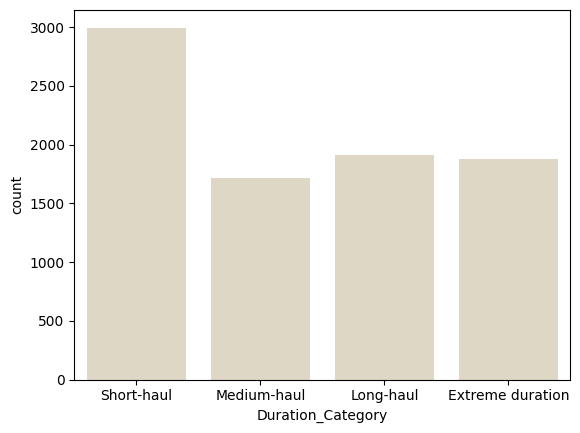

In [102]:
# Create a list of categories
flight_categories = ['Short-haul', 'Medium-haul', 'Long-haul']

# Create short_flights
# 避免找到 10h，因此要設定 ^從開頭開始
Short_flights = '^0h|^1h|^2h|^3h|^4h'

# Create medium_flights
Medium_flights = '^5h|^6h|^7h|^8h|^9h'

# Create long_flights
Long_flights = '10h|11h|12h|13h|14h|15h|16h'

# Create conditions for values in flight_categories to be created
conditions = [
    (planes['Duration'].str.contains(Short_flights)),
    (planes['Duration'].str.contains(Medium_flights)),
    (planes['Duration'].str.contains(Long_flights))
]

# Apply the conditions list to the flight_categories
planes['Duration_Category'] = np.select(
                                conditions,
                                flight_categories,
                                default='Extreme duration')
# Plot the counts of each category
sns.countplot(data=planes, 
              x='Duration_Category',
              order=['Short-haul', 'Medium-haul', 'Long-haul', 'Extreme duration'])
plt.show()

將飛行時間轉換成分鐘

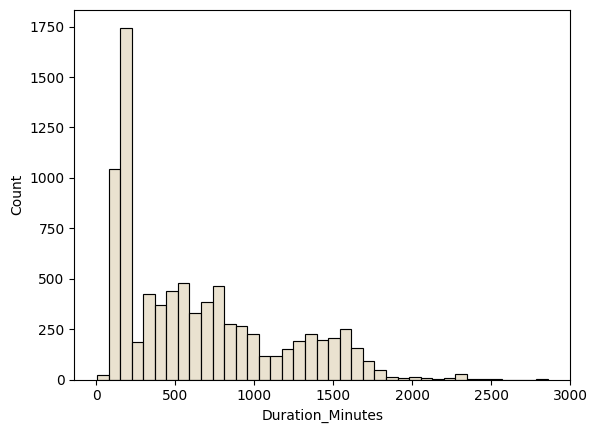

In [103]:
def convert_to_minutes(time_str):
    hours = 0
    minutes = 0

    # 使用正則表達式提取數字
    if match := re.search(r'(\d+)h', time_str): # 匹配小時
        hours = int(match.group(1))
    if match := re.search(r'(\d+)m', time_str): # 匹配分鐘
        minutes = int(match.group(1))

    # 計算總分鐘數
    return hours * 60 + minutes

planes['Duration_Minutes'] = planes['Duration'].apply(convert_to_minutes)

sns.histplot(data=planes, x='Duration_Minutes')
plt.show()

依照航空公司計算票價的標準差，同時計算總飛行航班。

In [104]:
# Price standard deviation by Airline
planes['airline_price_std'] = planes.groupby('Airline')['Price'].transform(lambda x: x.std())
print(planes[['Airline', 'airline_price_std']].value_counts())

Airline            airline_price_std
Jet Airways        4159.846432          3082
IndiGo             2245.529140          1632
Air India          3692.609285          1399
Multiple carriers  3558.323763           959
SpiceJet           1798.900648           653
Vistara            2888.915498           376
Air Asia           1979.826234           260
GoAir              2764.926625           147
Name: count, dtype: int64


計算各家航空公司的飛行時間的中位數。

In [105]:
# Median Duration by Airline
planes['airline_duration_minutes_median'] = planes.groupby('Airline')['Duration_Minutes'].transform(lambda x: x.median())
print(planes[['Airline', 'airline_duration_minutes_median']].value_counts())

Airline            airline_duration_minutes_median
Jet Airways        800.0                              3082
IndiGo             175.0                              1632
Air India          930.0                              1399
Multiple carriers  615.0                               959
SpiceJet           150.0                               653
Vistara            190.0                               376
Air Asia           170.0                               260
GoAir              175.0                               147
Name: count, dtype: int64


依照目的地，計算票價的平均值。

In [106]:
# Mean Price by Destination
planes['price_destination_mean'] = planes.groupby('Destination')['Price'].transform(lambda x: x.mean())

print(planes[['Destination', 'price_destination_mean']].value_counts())

Destination  price_destination_mean
Cochin       10473.585927              3631
Banglore     9093.622872               2291
Delhi        5248.541082                998
New Delhi    11579.306944               720
Hyderabad    5190.274021                562
Kolkata      4907.156863                306
Name: count, dtype: int64


觀察票價售出的數量，長條圖呈現右偏差。

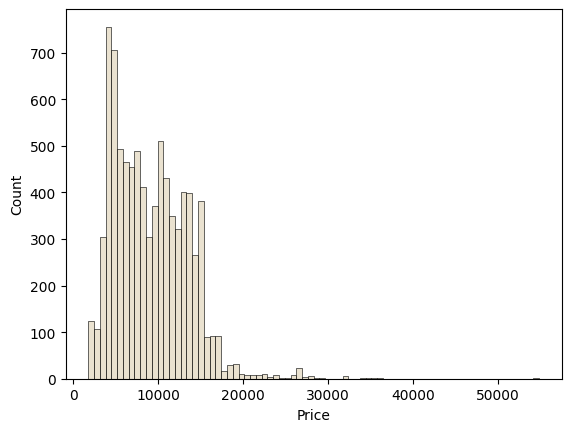

In [107]:
sns.histplot(data=planes, x='Price')
plt.show()

在價格欄位，最高的金額與中位數相差近6倍，表示有異常值無法準確代表數據。
因次我們來計算 Price 的 IQR 並將超出範圍的值刪除。

In [108]:
planes['Price'].describe()

count     8508.000000
mean      9033.468441
std       4366.382574
min       1759.000000
25%       5228.000000
50%       8452.000000
75%      12242.000000
max      54826.000000
Name: Price, dtype: float64

In [109]:
print(f'刪除價格差異值前的數量: {planes.shape}')

# Find the 75th and 25th percentiles
price_seventy_fifth = planes['Price'].quantile(0.75)
price_twenty_fifth = planes['Price'].quantile(0.25)

# Calculate iqr
prices_iqr = price_seventy_fifth - price_twenty_fifth

upper = price_seventy_fifth + (prices_iqr * 1.5)
lower = price_twenty_fifth - (prices_iqr * 1.5)

# Subset the data
planes = planes[(planes['Price']<upper) & (planes["Price"]>lower)]

print(f'刪除價格差異值後的數量: {planes.shape}')
planes['Price'].describe()



刪除價格差異值前的數量: (8508, 16)
刪除價格差異值後的數量: (8438, 16)


count     8438.000000
mean      8877.466046
std       4001.838236
min       1759.000000
25%       5224.000000
50%       8372.000000
75%      12121.000000
max      22270.000000
Name: Price, dtype: float64

將 Total_Stops 改成數字型態

In [110]:
planes['Total_Stops'].value_counts()

Total_Stops
1 stop      4411
non-stop    2784
2 stops     1207
3 stops       35
4 stops        1
Name: count, dtype: int64

In [111]:
planes['Total_Stops'] = planes['Total_Stops'].str.replace(' stops', '')
planes['Total_Stops'] = planes['Total_Stops'].str.replace(' stop', '')
planes['Total_Stops'] = planes['Total_Stops'].str.replace('non-stop', '0')
planes['Total_Stops'] = planes['Total_Stops'].astype(int)

In [112]:
planes.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Duration_Category,Duration_Minutes,airline_price_std,airline_duration_minutes_median,price_destination_mean
0,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2,No info,13882.0,Extreme duration,1140,4159.846432,800.0,10473.585927
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1,No info,6218.0,Medium-haul,325,2245.529140,175.0,9093.622872
2,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1,No info,13302.0,Short-haul,285,2245.529140,175.0,11579.306944
3,SpiceJet,24/06/2019,Kolkata,Banglore,CCU → BLR,09:00,11:25,2h 25m,0,No info,3873.0,Short-haul,145,1798.900648,150.0,9093.622872
4,Jet Airways,12/03/2019,Banglore,New Delhi,BLR → BOM → DEL,18:55,10:25 13 Mar,15h 30m,1,In-flight meal not included,11087.0,Long-haul,930,4159.846432,800.0,11579.306944


我們可以看出，停留的站數與飛行的時間有密切的關係，除此之外，停留的站數與價格的關係，比飛行時間與價格有更強的相關性。

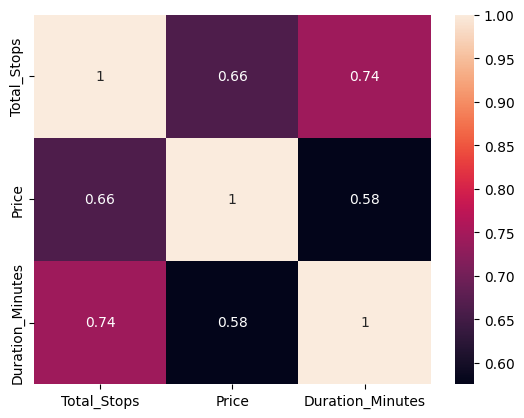

In [113]:
numeric_cols = planes.select_dtypes(include=['number'])
numeric_cols = numeric_cols.drop(columns=['airline_price_std', 'airline_duration_minutes_median', 'price_destination_mean'])

sns.heatmap(numeric_cols.corr(), annot=True)
plt.show()

我們知道機票在不同的月份價格也會不同，如果說在星期幾起飛，是否也會影響機票的價格呢？
先將日期欄位，轉換成 pandas 的日期格式。

In [114]:
planes['Date_of_Journey'] = pd.to_datetime(planes['Date_of_Journey'], format='%d/%m/%Y')

In [115]:
planes['month'] = planes['Date_of_Journey'].dt.month
planes['weekday'] = planes['Date_of_Journey'].dt.weekday
planes[['month', 'weekday', 'Date_of_Journey']].head()

,month,weekday,Date_of_Journey
0,6,6,2019-06-09
1,5,6,2019-05-12
2,3,4,2019-03-01
3,6,0,2019-06-24
4,3,1,2019-03-12


最多航班為星期三，最少航班為星期五。

In [130]:
weekday_planes = planes['weekday'].value_counts()
weekday_planes

weekday
2    1641
0    1472
3    1453
5    1339
6    1171
1     695
4     667
Name: count, dtype: int64

In [136]:
weekday_price = planes.groupby('weekday')['Price'].median()
weekday_price

weekday
0    7893.0
1    8907.0
2    8586.0
3    8452.0
4    6528.0
5    8372.0
6    9443.0
Name: Price, dtype: float64

或許顧客會因為更方便的出發時間或抵達時間而支付更高的票價。
因次我將 `Dep_Time` 與 `Arrival_Hour` 轉換成日期型態。但是 `Arrival_Hour` 的時間會隨著飛行時間拉長而跨日，因此我們需要將時間用 `slice` 取出前 5 個字串，也就是小時與時間後，才能轉換成日期型態。但 pandas 的日期型態，同時包含了年月日，我們在使用 `dt.hour` 提取我們要的小時。

In [116]:
planes['Dep_Hour'] = pd.to_datetime(planes['Dep_Time'], format='%H:%M')
planes['Dep_Hour'] = planes['Dep_Hour'].dt.hour

planes['Arrival_Time_slice'] = planes['Arrival_Time'].str.slice(0,5)
planes['Arrival_Hour'] = pd.to_datetime(planes['Arrival_Time_slice'], format='%H:%M')
planes['Arrival_Hour'] = planes['Arrival_Hour'].dt.hour

planes.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,...,Duration_Category,Duration_Minutes,airline_price_std,airline_duration_minutes_median,price_destination_mean,month,weekday,Dep_Hour,Arrival_Time_slice,Arrival_Hour
0,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2,No info,...,Extreme duration,1140,4159.846432,800.0,10473.585927,6,6,9,04:25,4
1,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1,No info,...,Medium-haul,325,2245.529140,175.0,9093.622872,5,6,18,23:30,23
2,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1,No info,...,Short-haul,285,2245.529140,175.0,11579.306944,3,4,16,21:35,21
3,SpiceJet,2019-06-24,Kolkata,Banglore,CCU → BLR,09:00,11:25,2h 25m,0,No info,...,Short-haul,145,1798.900648,150.0,9093.622872,6,0,9,11:25,11
4,Jet Airways,2019-03-12,Banglore,New Delhi,BLR → BOM → DEL,18:55,10:25 13 Mar,15h 30m,1,In-flight meal not included,...,Long-haul,930,4159.846432,800.0,11579.306944,3,1,18,10:25,10


我們新增了更多欄位後，來觀察是否有更多影響票價的因素。
不過我們沒有進一步發現更多的關聯性。

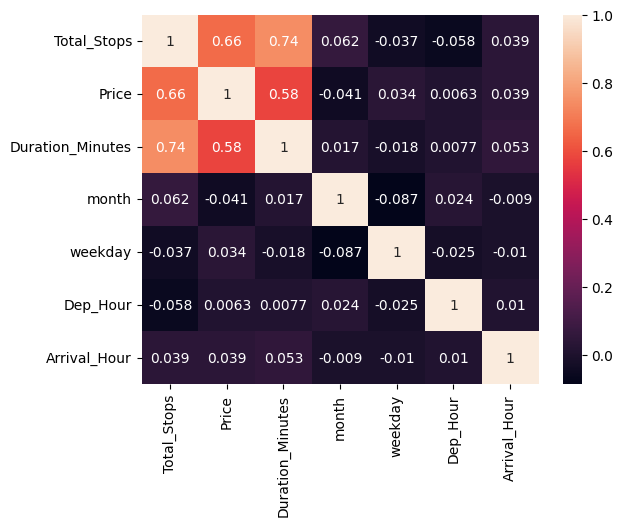

In [117]:
numeric_cols = planes.select_dtypes(include=['number'])
numeric_cols = numeric_cols.drop(columns=['airline_price_std', 'airline_duration_minutes_median', 'price_destination_mean'])
sns.heatmap(numeric_cols.corr(), annot=True)
plt.show()

我們試著將票價分層不同的等級。

我們利用四分位數來當作價格的區間來平均分配。

In [118]:
planes['Price'].describe()

count     8438.000000
mean      8877.466046
std       4001.838236
min       1759.000000
25%       5224.000000
50%       8372.000000
75%      12121.000000
max      22270.000000
Name: Price, dtype: float64

In [119]:
twenty_fifth = planes['Price'].quantile(0.25)
median = planes['Price'].median()
seventy_fifth = planes['Price'].quantile(0.75)
maximum = planes['Price'].max()

labels = ['Economy', 'Premium Economy', 'Business Class', 'First Class']
bins = [0, twenty_fifth, median, seventy_fifth, maximum]

planes['Price_Category'] = pd.cut(planes['Price'], labels=labels, bins=bins)

planes[['Price', 'Price_Category']].head()

,Price,Price_Category
0,13882.0,First Class
1,6218.0,Premium Economy
2,13302.0,First Class
3,3873.0,Economy
4,11087.0,Business Class


我們可以觀察到 Jet Airways 擁有最多的頭等艙機票，而 IndiGo 與 Spicejet 大部分則是經濟艙機票。

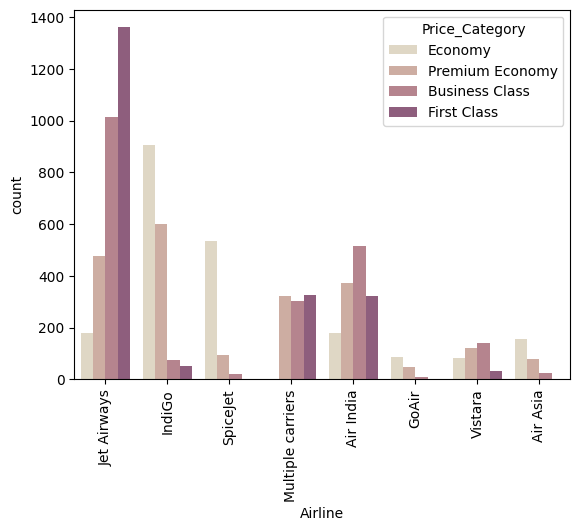

In [120]:
sns.countplot(data=planes, x='Airline', hue='Price_Category')
plt.xticks(rotation=90)
plt.show()

## Spurious correlaton
當我們觀察飛行時間與票價間的關係，可以看出停留的站數取決於飛行的時間。我們原本以為停留的站數取決於價格，而實際上是與飛行時間相關。

<Axes: xlabel='Duration_Minutes', ylabel='Price'>

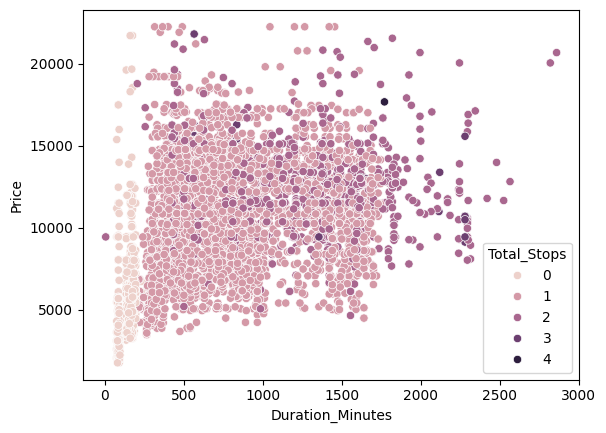

In [121]:
sns.scatterplot(data=planes, x='Duration_Minutes', y='Price', hue='Total_Stops')

觀察紅眼班機的是否有較便宜的票價，設定紅眼班機的時間為 晚上 22 點至 早上 7 點間的班機。

In [122]:
planes['redeye'] = planes['Dep_Hour'].apply(lambda x: 1 if ( x >= 22 or x <= 7) else 0 )

redeye_avg_price = planes.groupby('redeye')['Price'].mean()
redeye_price_diff = redeye_avg_price.loc[0] - redeye_avg_price.loc[1]

print('平均票價')
print(f'紅眼班機: {redeye_avg_price[1]:.2f} \n非紅眼班機: {redeye_avg_price[0]:.2f}')
print(f'平均票價價差: {redeye_price_diff:.2f}')

redeye_min_price = planes.groupby('redeye')['Price'].min()
redeye_min_price_diff = redeye_min_price.loc[0] - redeye_min_price.loc[1]
print('最低票價')
print(f'紅眼班機: {redeye_min_price[1]:.2f} \n非紅眼班機: {redeye_min_price[0]:.2f}')
print(f'最低票價價差: {redeye_min_price_diff:.2f}')

平均票價
紅眼班機: 8278.89 
非紅眼班機: 9129.62
平均票價價差: 850.73
最低票價
紅眼班機: 1759.00 
非紅眼班機: 1965.00
最低票價價差: 206.00


觀察各家航空公司的紅眼班機，可以發現廉價航空 Air Asia 提供較多的紅眼班機。

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'Jet Airways'),
  Text(1, 0, 'IndiGo'),
  Text(2, 0, 'SpiceJet'),
  Text(3, 0, 'Multiple carriers'),
  Text(4, 0, 'Air India'),
  Text(5, 0, 'GoAir'),
  Text(6, 0, 'Vistara'),
  Text(7, 0, 'Air Asia')])

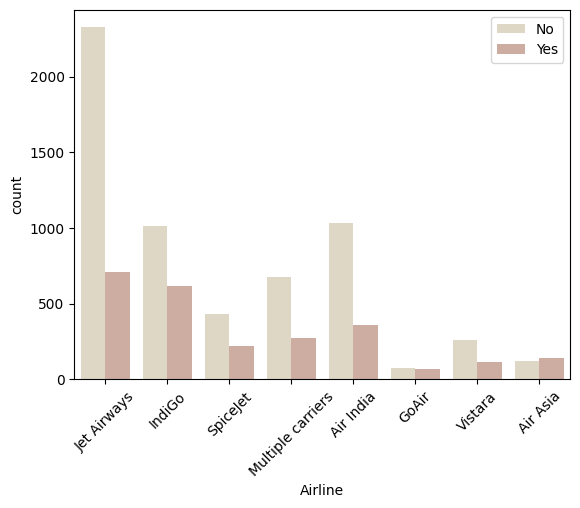

In [138]:
sns.countplot(x='Airline', data=planes ,hue='redeye')
plt.legend(labels=['No', 'Yes'])
plt.xticks(rotation=45)

票價也會因為停留的站數而越來越貴。

<Axes: xlabel='Total_Stops', ylabel='Price'>

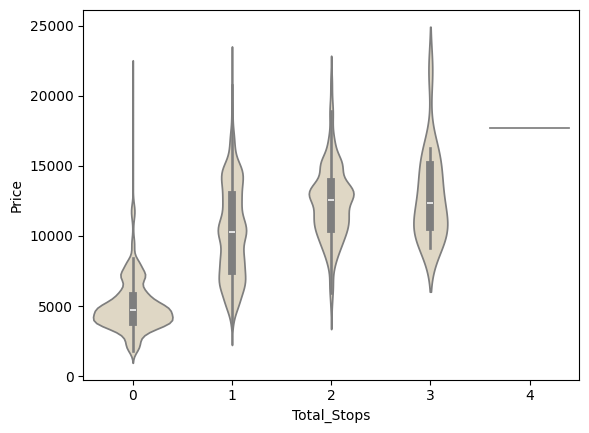

In [124]:
sns.violinplot(x='Total_Stops', y='Price', data=planes)

In [129]:
jet_airways_stops = planes[planes['Airline']=='Jet Airways']['Total_Stops'].value_counts()
jet_airways_stops

Total_Stops
1    1969
2     557
0     506
Name: count, dtype: int64